In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

# Load and Clean Dataset

In [2]:
# # Load the dataset (replace 'songs.csv' with your actual file)
file_path = Path('Resources/spotify_dataset.csv')
songs_df = pd.read_csv(file_path)
songs_df.shape

(41099, 20)

In [3]:
# Remove duplicate songs
songs_df = songs_df.drop_duplicates(subset=['track', 'artist'], keep='first')

print(f"DataFrame after removing duplicates: {songs_df.shape}")

DataFrame after removing duplicates: (39996, 20)


In [4]:
songs_df = songs_df.reset_index(drop=True)

In [5]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39996 entries, 0 to 39995
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             39996 non-null  object 
 1   artist            39996 non-null  object 
 2   uri               39996 non-null  object 
 3   danceability      39996 non-null  float64
 4   energy            39996 non-null  float64
 5   key               39996 non-null  int64  
 6   loudness          39996 non-null  float64
 7   mode              39996 non-null  int64  
 8   speechiness       39996 non-null  float64
 9   acousticness      39996 non-null  float64
 10  instrumentalness  39996 non-null  float64
 11  liveness          39996 non-null  float64
 12  valence           39996 non-null  float64
 13  tempo             39996 non-null  float64
 14  duration_ms       39996 non-null  int64  
 15  time_signature    39996 non-null  int64  
 16  chorus_hit        39996 non-null  float6

In [6]:
zero_count = (songs_df['instrumentalness'] == 0).sum()
print(zero_count)


11435


In [7]:
# Normalize dataset columns for searching
songs_df['track_lower'] = songs_df['track'].str.strip().str.lower()
songs_df['artist_lower'] = songs_df['artist'].str.strip().str.lower()

In [8]:
songs_df['decade'] = songs_df['decade'].replace({
    '60s': 1960.0,
    '70s': 1970.0,
    '80s': 1980.0,
    '90s': 1990.0,
    '00s': 2000.0, 
    '10s': 2010.0
}).astype(float)

/var/folders/zb/zlwnk3g95gq8bzw6chr9cs_m0000gn/T/ipykernel_69647/2433580227.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  songs_df['decade'] = songs_df['decade'].replace({


# Features and Scaling

In [9]:
# Select relevant features for the model

features = [
# 'track',
#  'artist',
#  'uri',
 'danceability',
 'energy',
#  'key',
#  'loudness',
#  'mode',
#  'speechiness',
 'acousticness',
#  'instrumentalness',
#  'liveness',
 'valence',
#  'tempo',
#  'duration_ms',
#  'time_signature',
#  'chorus_hit',
#  'sections',
 'popularity',
 'decade'
 ]


X = songs_df[features]



In [10]:
scaler = MinMaxScaler()
# Ensure indices of scaled features match songs_df
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=features,
    index=songs_df.index  # Match the original index
)

## Apply Weights

In [11]:
# Feature weighting
weights = {
    'danceability': 1.3,
    'energy': 1.8,
    'acousticness': 0.8,
    'valence': 1.5,
    'popularity': 0.5,
    'decade': 0.4
}

In [39]:
# Apply the weights to the scaled features
weighted_features = X_scaled * pd.Series(weights)

In [40]:
weighted_features.head()

,danceability,energy,acousticness,valence,popularity,decade
0,0.548684,1.115828,0.393574,1.272590,0.5,0.0
1,0.655263,0.908776,0.014458,1.200301,0.0,0.0
2,0.864474,1.168041,0.679518,1.367470,0.0,0.0
3,0.776316,0.980794,0.567068,1.456325,0.0,0.0
4,0.677632,1.376894,0.688353,1.364458,0.0,0.0


# NN Model

In [42]:
# Train a k-Nearest Neighbors model
model = NearestNeighbors(n_neighbors=15, algorithm='ball_tree')
model.fit(weighted_features)

NearestNeighbors(algorithm='ball_tree', n_neighbors=15)

# Visual Code

In [30]:
def visualize_features(original_features, recommendation_features, feature_names, song_title, artist_name):

    # Creates a bar chart comparing features of the input song with the recommendations.
    recommendation_features = np.array(recommendation_features)
    avg_recommendation_features = recommendation_features.mean(axis=0)

    x = np.arange(len(feature_names))

    plt.figure(figsize=(10, 6))
    plt.bar(x - 0.2, original_features.flatten(), width=0.4, label=f"{song_title} by {artist_name}")
    plt.bar(x + 0.2, avg_recommendation_features, width=0.4, label="Recommended Songs (Average)")
    plt.xticks(x, feature_names, ha='right')
    plt.title(f"{song_title} by {artist_name} vs Recommendations")
    plt.ylabel("Scaled Feature Values")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [18]:
def visualize_tsne(original_features, recommendation_features, recommendations, song_title, artist_name):
    # Creates a t-SNE scatter plot to visualize the input song and its recommendations.
    
    all_features = np.vstack([original_features, recommendation_features])  # Stack features
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(len(all_features) - 1, 5))  # Adjust perplexity
    tsne_results = tsne.fit_transform(all_features)

    plt.figure(figsize=(8, 6))
    
    # Plot the input song
    plt.scatter(tsne_results[0, 0], tsne_results[0, 1], color='red', s=120)
    plt.text(tsne_results[0, 0] + 0.5, tsne_results[0, 1] + 0.5, f"{song_title}", fontsize=10)

    # Plot the recommended songs and display their full track names
    for i, (track, artist) in enumerate(recommendations):
        plt.scatter(tsne_results[i + 1, 0], tsne_results[i + 1, 1], color='blue', s=60)
        plt.text(tsne_results[i + 1, 0] + 0.5, tsne_results[i + 1, 1] + 0.5, f"#{i+1}: {track}", fontsize=9)

    plt.title(f"{song_title} by '{artist_name}' and Recommendations")
    plt.tight_layout()
    plt.show()

In [48]:
def recommend_songs_with_visuals(song_title, artist_name, num_recommendations=5):
    # Preprocess input
    song_title = song_title.strip().lower()
    artist_name = artist_name.strip().lower()

    # Filter the dataset for the input song and artist with case-insensitive partial matching
    song_row = songs_df[
        (songs_df['track_lower'].str.contains(song_title)) & 
        (songs_df['artist_lower'].str.contains(artist_name))
    ]
    
    if song_row.empty:
        print(f"Error: Song '{song_title}' by '{artist_name}' not found in the dataset.")
        return

    # Get the index and weighted features of the input song
    song_index = song_row.index[0]
    song_features = weighted_features.loc[song_index].values.reshape(1, -1)  # Use weighted_features here

    # Convert to DataFrame with correct feature names
    song_features_df = pd.DataFrame(song_features, columns=weighted_features.columns)

    # Find nearest neighbors
    distances, indices = model.kneighbors(song_features_df)
    
    # Map indices back to the original DataFrame
    recommendations = []
    recommendation_features = []  # Store features of recommended songs

    for i in indices.flatten():
        original_index = songs_df.index[i]  # Map to original index
        if (songs_df.loc[original_index, 'track_lower'] != song_row.iloc[0]['track_lower'] and 
            songs_df.loc[original_index, 'artist_lower'] != song_row.iloc[0]['artist_lower']):
            recommendations.append((songs_df.loc[original_index, 'track'], songs_df.loc[original_index, 'artist']))
            recommendation_features.append(weighted_features.loc[original_index].values)  # Add weighted features
        if len(recommendations) >= num_recommendations:
            break

    # Print recommendations with the correct original case for song and artist names
    original_song = song_row.iloc[0]['track']
    original_artist = song_row.iloc[0]['artist']
    
    print(f"Recommendations for '{original_song}' by {original_artist}:")
    for track, artist in recommendations:
        print(f"- {track} by {artist}")

    # Visualize features comparison
    visualize_features(
        song_features, recommendation_features, weighted_features.columns, original_song, original_artist
    )

    # Visualize t-SNE of input song and recommendations
    visualize_tsne(
        song_features, recommendation_features, recommendations, original_song, original_artist
    )

Recommendations for 'Ladies Night' by Kool & The Gang:
- Backfield In Motion by Mel And Tim
- Love Power by Willie Hutch
- Boogie Down by Eddie Kendricks
- Take A Chance On Me by ABBA
- Saturday Night, Sunday Morning by Thelma Houston
- Ecstasy by Ohio Players
- It's Been A Long Time by The New Birth
- Hollywood by Boz Scaggs
- One Less Set Of Footsteps by Jim Croce
- This Will Be by Natalie Cole
- Don't Knock My Love by Diana Ross & Marvin Gaye
- I Can't Leave You Alone by George McCrae


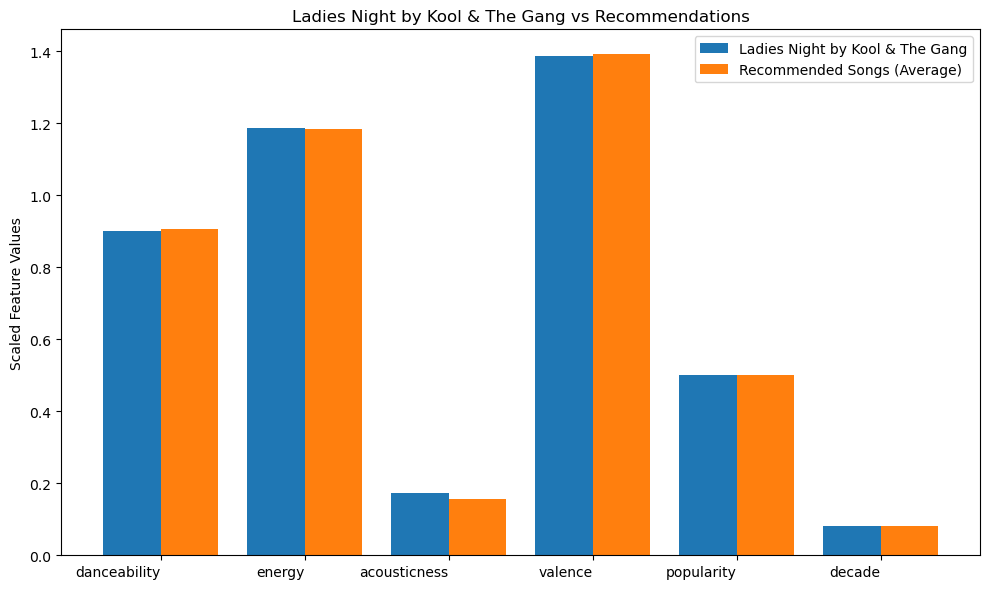

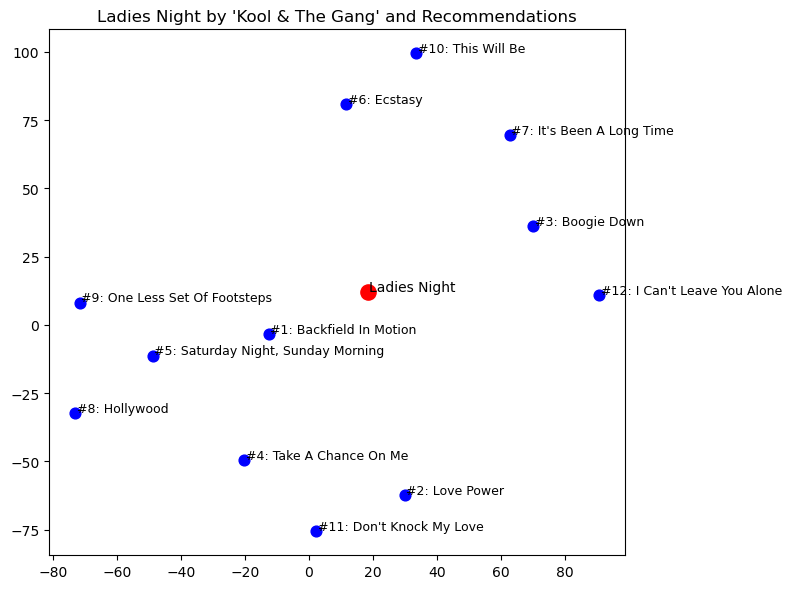

In [58]:
recommend_songs_with_visuals("ladies", "kool", 12)

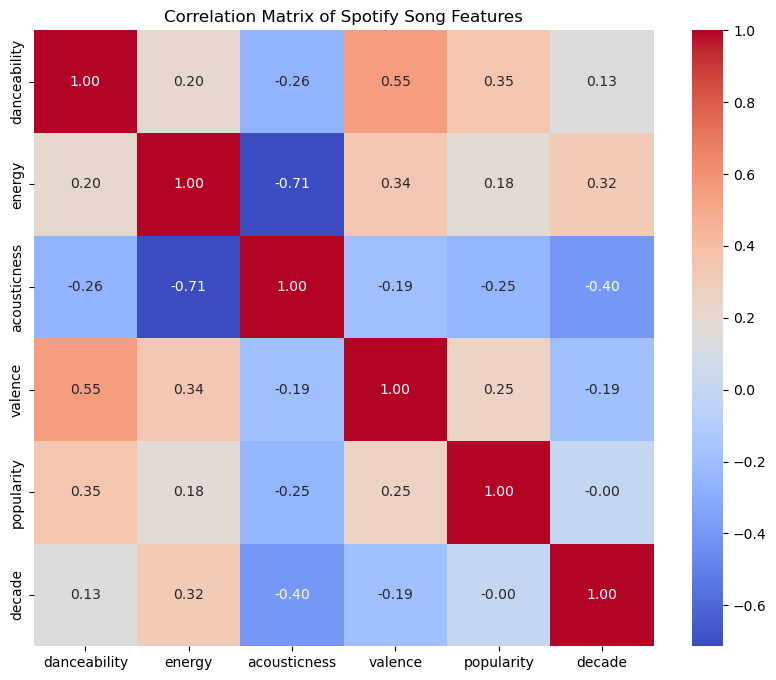

In [61]:
# Compute the correlation matrix for the original features (before scaling)
correlation_matrix = X.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Spotify Song Features")
plt.show()